### IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5456400315782752001, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11154422528
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11834721230809287882
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 2664 images belonging to 3 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 665 images belonging to 3 classes.


100%|██████████| 4/4 [00:48<00:00, 12.10s/it]


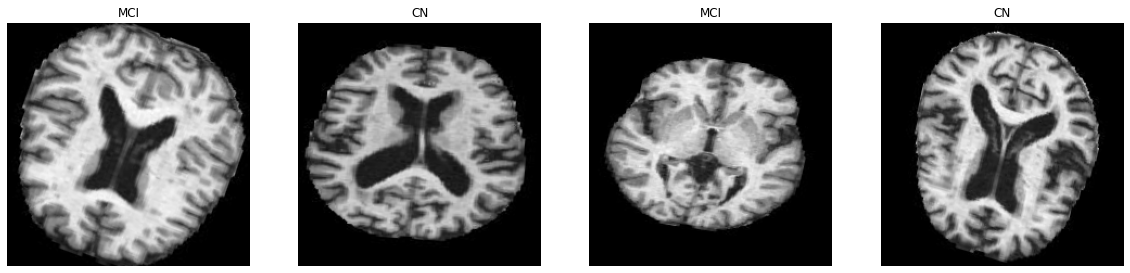

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(20,20))

for i in tqdm(range(0,4)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('AD')
    elif a[2] == 1:
        ax[i].set_title('CN')
    elif a[1] == 1:
        ax[i].set_title('MCI')
   

### MODEL BUILDING

In [ ]:
# Model Initialization

base_model = ResNet152(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

234700800/234698864 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_4 (Activation)    (None, 2048)             

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
21/21 [==============================] - 52s 2s/step - loss: 1.2448 - auc: 0.7411 - val_loss: 0.9188 - val_auc: 0.9013

Epoch 00001: val_auc improved from -inf to 0.90129, saving model to ./best_weights.hdf5
Epoch 2/500
21/21 [==============================] - 41s 2s/step - loss: 0.7057 - auc: 0.9075 - val_loss: 0.6113 - val_auc: 0.9011

Epoch 00002: val_auc did not improve from 0.90129
Epoch 3/500
21/21 [==============================] - 41s 2s/step - loss: 0.6757 - auc: 0.9001 - val_loss: 0.6219 - val_auc: 0.8948

Epoch 00003: val_auc did not improve from 0.90129
Epoch 4/500
21/21 [==============================] - 41s 2s/step - loss: 0.6207 - auc: 0.9094 - val_loss: 0.6110 - val_auc: 0.9105

Epoch 00004: val_auc improved from 0.90129 to 0.91049, saving model to ./best_weights.hdf5
Epoch 5/500
21/21 [==============================] - 41s 2s/step - loss: 0.5940 - auc: 0.9170 - val_loss: 0.6671 - val_auc: 0.8579

Epoch 00005: val_auc did not improve from 0.91049
Epoch 6/500

### MODEL EVALUATION

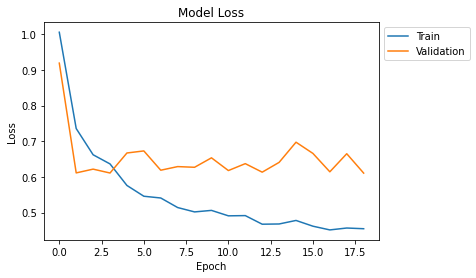

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

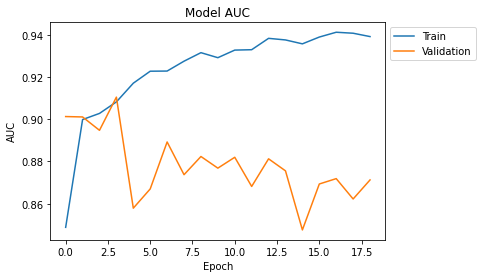

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 831 images belonging to 3 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

7/7 [==============================] - 200s 33s/step - loss: 0.4761 - auc: 0.9368


[0.47610554099082947, 0.9368175864219666]

99.34 % chances are there that the image is CN


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


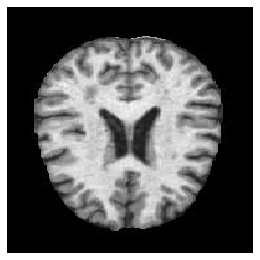

In [ ]:
# Test Case 1: CN

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Alzheimer_s dataset/test/CN/26 (81).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


60.12 % chances are there that the image is MCI


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


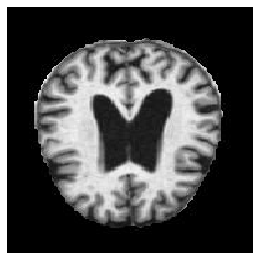

In [ ]:
# Test Case 2: MCI

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Alzheimer_s dataset/test/MCI/31 (21).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


80.05 % chances are there that the image is AD


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


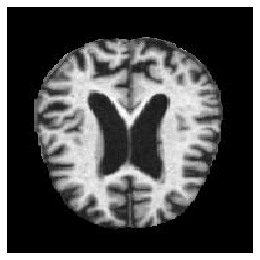

In [31]:
# Test Case 3: AD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Alzheimer_s dataset/test/AD/28 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

Conclusion:

So, we have finally built are deep learning model using ResNet152 transfer learning algorithm and acheived and AUC-91.04%.